# A Model to predict user conversion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# The train_users table

In [2]:
# import the train_users table

train_users = pd.read_csv('csvdata/train_users_2.csv')
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
# clean up the timestamps in the train_users dataframe 

train_users.timestamp_first_active = pd.to_datetime(train_users.timestamp_first_active.astype(str))
train_users.date_first_booking = pd.to_datetime(train_users.date_first_booking)
train_users.date_account_created = pd.to_datetime(train_users.date_account_created)

train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
# only keep the users for whom date_account_created matches timestamp_first_active 
# this is true for all the users in the test_users table, and for almost all the users in the train_users table 

train_users = train_users[train_users.timestamp_first_active.dt.date == train_users.date_account_created.dt.date]

In [5]:
# calculate the age buckets and add them to the train_users table 

def calc_age_bucket(age):
    '''
    this function calculates five year age buckets, given the age
    '''
    if age < 100.0:
        return (age // 5.0) + 1
    elif age >= 100.0:
        return 21.0
    elif np.isnan(age):
        return 0.0

train_users['age_bucket'] = train_users.age.apply(calc_age_bucket).astype('category')

In [6]:
# create features: year, month, day and dayofweek from date_account_created. 

train_users.loc[:,'year'] = train_users.date_account_created.dt.year.astype('category')
train_users.loc[:,'month'] = train_users.date_account_created.dt.month.astype('category')
#train_users.loc[:,'day'] = train_users.date_account_created.dt.day.astype('category')
train_users.loc[:,'dayofweek'] = train_users.date_account_created.dt.dayofweek.astype('category')

# mark a the following columns as categorical data
mylist = ['gender', 'signup_method', 'language', 'affiliate_channel', 
          'affiliate_provider', 'first_affiliate_tracked', 'signup_flow', 
          'signup_app', 'first_device_type', 'first_browser','age_bucket']
for x in mylist:
    train_users.loc[:,x] = train_users[x].astype('category')

#add seasons
mydict = {2:'spring', 3:'spring', 4:'spring', 
          5:'summer', 6:'summer', 7:'summer', 
          8:'fall', 9:'fall', 10:'fall',
          11:'winter', 12:'winter', 1:'winter'}
train_users.loc[:,'season'] = train_users.date_account_created.dt.month.apply(lambda x: mydict[x]).astype('category')

# only keep the users from 2014 for now - 
train_users = train_users[(train_users.year == 2014)]

In [7]:
# use 'id' as the index and drop the columns that are not needed anymore

ids = train_users.id
train_users = train_users.set_index('id')
train_users = train_users.drop(['date_account_created', 'timestamp_first_active', 'age', 'country_destination'], axis=1)

In [8]:
# separate the date_first_booking column as a column of 1/0 
# these are the labels that indicate the conversion of the user 

y_users = train_users.date_first_booking.notnull().astype(int)

# drop all the date_first_booking values - they're not present in the test_users table. 

train_users = train_users.drop('date_first_booking', axis=1)

# The sessions table

In [9]:
# import the sessions table

sessions = pd.read_csv('csvdata/sessions.csv')
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [10]:
# add a large numbe of features coming from the sessions table 
# this includes stuff such as number of clicks and the counts of many other things 
# all of this is numerical data

for y in ['action', 'action_type', 'action_detail']:
    df = sessions.groupby(['user_id', y]).size().unstack()
    for x in df.columns:
        s = df[x]
        train_users[y + '_' + x] = train_users.join(s)[x].fillna(0)

# now train_users has a large number of features derived from the sessions table 
train_users.values.shape

(76429, 539)

In [11]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [12]:
# convert the categorical variables into dummy variables

X_users = pd.get_dummies(train_users)

# scale to zero mean and unit variance
#X_users = pd.DataFrame(scale(X_users.values), index=X_users.index, columns=X_users.columns)

X_users.head()

,action_10,action_11,action_12,action_15,action_about_us,action_accept_decline,action_account,action_acculynk_bin_check_failed,action_acculynk_bin_check_success,action_acculynk_load_pin_pad,...,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_fall,season_spring,season_summer,season_winter
id,,,,,,,,,,,,,,,,,,,,,
d1mm9tcy42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
yo8nz8bqcq,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
4grx6yxeby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
ncf87guaf0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
4rvqpxoh3h,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1


In [13]:
# pca = PCA(n_components=400)
# pca.fit(X_users)
# X_users = pd.DataFrame(pca.transform(X_users), X_users.index)

#pca.explained_variance_ratio_[:400].sum()

In [14]:
X_users.values.shape

(76429, 720)

In [15]:
# X_users = X_users[X_users < 6].dropna()
# X_users.values.shape

# Logistic Regression

Fold 1 out of 5:
training misclassification (percentage) : 22.1758827666
training log loss : 0.477740225826
training roc auc score : 0.842074742228
validation misclassification (percentage) : 22.3014523093
validation log loss : 0.478733626579
validation roc auc score : 0.84003270265
------------------------------------------------------------------------------------------


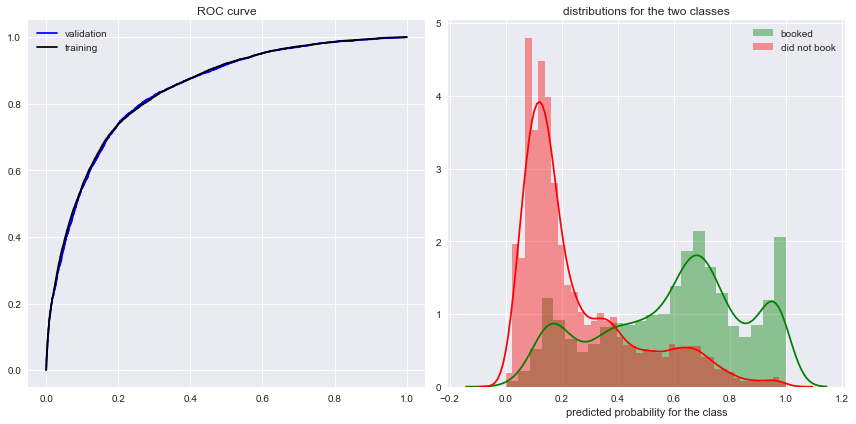

******************************************************************************************
Fold 2 out of 5:
training misclassification (percentage) : 22.2069574604
training log loss : 0.477535186631
training roc auc score : 0.84152675573
validation misclassification (percentage) : 22.2425749051
validation log loss : 0.479550408326
validation roc auc score : 0.839904006556
------------------------------------------------------------------------------------------


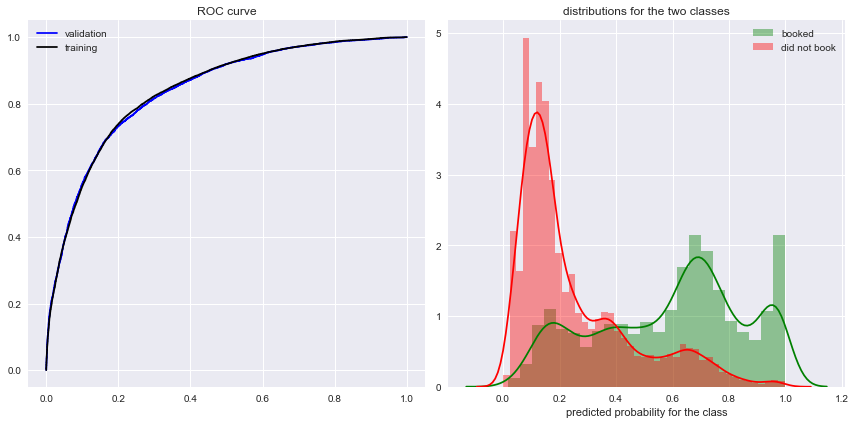

******************************************************************************************
Fold 3 out of 5:
training misclassification (percentage) : 22.211863991
training log loss : 0.476416567254
training roc auc score : 0.842150442265
validation misclassification (percentage) : 22.3799555149
validation log loss : 0.484714622113
validation roc auc score : 0.836585086613
------------------------------------------------------------------------------------------


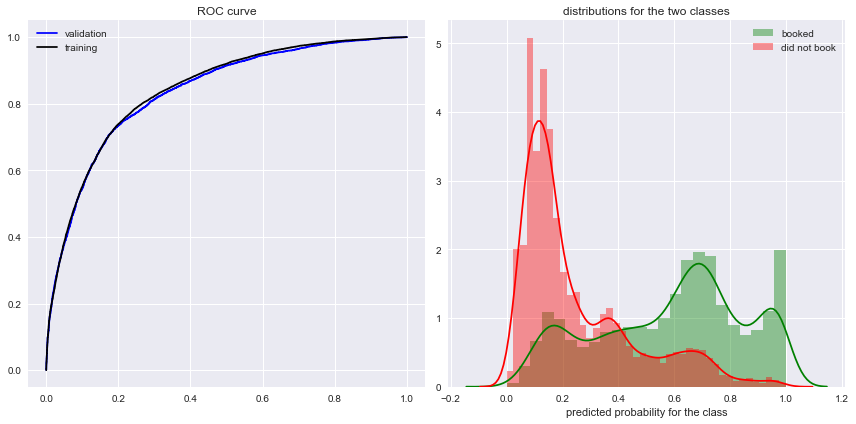

******************************************************************************************
Fold 4 out of 5:
training misclassification (percentage) : 22.2527517459
training log loss : 0.47699735463
training roc auc score : 0.841913539296
validation misclassification (percentage) : 22.1706136334
validation log loss : 0.482352083382
validation roc auc score : 0.839443779827
------------------------------------------------------------------------------------------


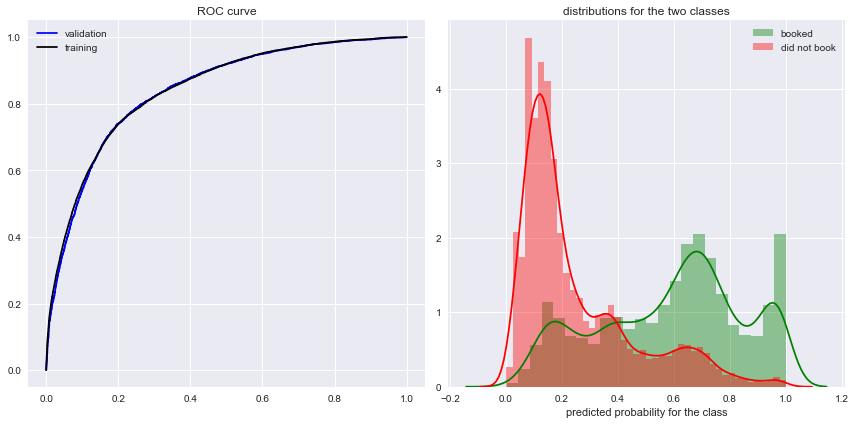

******************************************************************************************
Fold 5 out of 5:
training misclassification (percentage) : 22.0266910899
training log loss : 0.47618961346
training roc auc score : 0.842550900008
validation misclassification (percentage) : 23.2973503435
validation log loss : 0.491057496426
validation roc auc score : 0.831804480514
------------------------------------------------------------------------------------------


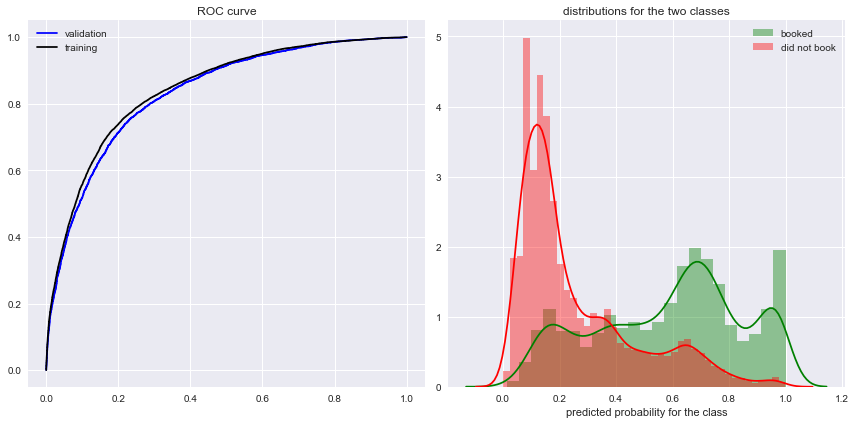

******************************************************************************************


In [16]:
kf = KFold(n_splits=5, shuffle=True)
fold = 0
for train, cv in kf.split(X_users):
    fold = fold + 1
    print 'Fold', fold, 'out of 5:'
    X_train, X_cv = X_users.iloc[train], X_users.iloc[cv]
    y_train, y_cv = y_users.iloc[train], y_users.iloc[cv]
    
#     # this code resample X_train and y_train:
#     samples = np.random.choice(len(X_train), 10000)
#     X_train = X_train.iloc[samples]
#     y_train = y_train.iloc[samples]
    
    # train a logistic regression classifier 
    clf = LogisticRegression(penalty='l2', C=0.1)
    #clf = MLPClassifier((8), activation='logistic', alpha=0.1)
    clf.fit(X_train, y_train)
    
    # check the performance on the training set
    predictions_train = clf.predict(X_train)
    E_train = (y_train != predictions_train).sum() * 100. / float(len(y_train))
    print 'training misclassification (percentage) :', E_train
    prob_train = clf.predict_proba(X_train)
    print 'training log loss :', log_loss(y_train, prob_train)
    print 'training roc auc score :', roc_auc_score(y_train, prob_train[:, 1])
    
    # check the performance on the validation set
    predictions_cv = clf.predict(X_cv)
    E_cv = (y_cv != predictions_cv).sum() * 100. / float(len(y_cv))
    print 'validation misclassification (percentage) :', E_cv
    prob_cv = clf.predict_proba(X_cv)
    print 'validation log loss :', log_loss(y_cv, prob_cv)
    print 'validation roc auc score :', roc_auc_score(y_cv, prob_cv[:, 1])
    
    print '-'*90
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    
    # plot the roc curve and probability distributions of the two classes     
    fpr, tpr, thresholds = roc_curve(y_cv, prob_cv[:, 1])
    ax1.plot(fpr, tpr, label='validation', color='blue')
    fpr, tpr, thresholds = roc_curve(y_train, prob_train[:, 1])
    ax1.plot(fpr, tpr, label='training', color='black')
    ax1.legend()
    ax1.set_title('ROC curve')
    
    # plot the probability distribution for the two classes on the validation set
    distr_p1 = pd.Series(prob_cv[:, 1], index=y_cv).loc[1].values
    distr_p0 = pd.Series(prob_cv[:, 1], index=y_cv).loc[0].values
    ax2 = sns.distplot(distr_p1, color='green', label='booked')
    ax2 = sns.distplot(distr_p0, color='red', label='did not book')
    ax2.set_title('distributions for the two classes')
    ax2.set_xlabel('predicted probability for the class')
    ax2.legend()
    fig.tight_layout()
    plt.show()
    print '*'*90

In [17]:
# vary the threshold

for mythreshold in np.linspace(0.30, 0.70, 41):
    print 'threshold:', mythreshold, 'misclassification percentage:', 100. * ((prob_cv[:, 0] > mythreshold) == y_cv).sum()/float(len(y_cv))

threshold: 0.3 misclassification percentage: 27.3078181223
threshold: 0.31 misclassification percentage: 26.7713444553
threshold: 0.32 misclassification percentage: 26.3133791299
threshold: 0.33 misclassification percentage: 25.9535492313
threshold: 0.34 misclassification percentage: 25.5675498855
threshold: 0.35 misclassification percentage: 25.175008178
threshold: 0.36 misclassification percentage: 24.9591102388
threshold: 0.37 misclassification percentage: 24.7235852143
threshold: 0.38 misclassification percentage: 24.5861956166
threshold: 0.39 misclassification percentage: 24.2787046124
threshold: 0.4 misclassification percentage: 24.1805691855
threshold: 0.41 misclassification percentage: 24.0039254171
threshold: 0.42 misclassification percentage: 23.7880274779
threshold: 0.43 misclassification percentage: 23.6637226039
threshold: 0.44 misclassification percentage: 23.6506378803
threshold: 0.45 misclassification percentage: 23.5132482826
threshold: 0.46 misclassification percentag

# Random Forests

Fold 1 out of 5:
training misclassification (percentage) : 1.640416728
training log loss : 0.161796665478
training roc auc score : 0.997023328906
validation misclassification (percentage) : 22.6416328667
validation log loss : 0.484640347201
validation roc auc score  : 0.836028571961
oob score: 0.768428111149
------------------------------------------------------------------------------------------


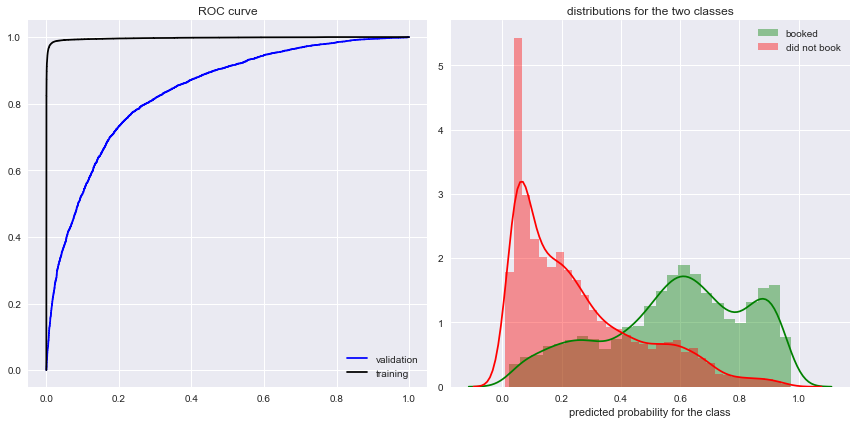

******************************************************************************************
Fold 2 out of 5:
training misclassification (percentage) : 1.68621101353
training log loss : 0.162402732233
training roc auc score : 0.996914523496
validation misclassification (percentage) : 22.2425749051
validation log loss : 0.482721528879
validation roc auc score  : 0.836013697809
oob score: 0.767561290745
------------------------------------------------------------------------------------------


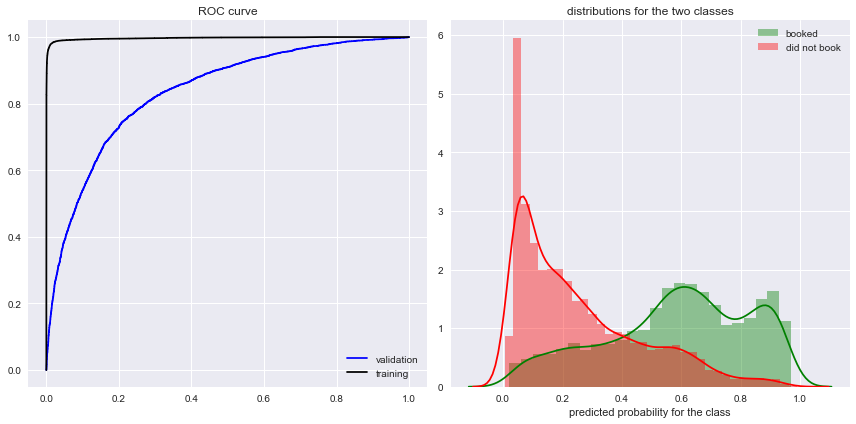

******************************************************************************************
Fold 3 out of 5:
training misclassification (percentage) : 1.61915509543
training log loss : 0.16168810971
training roc auc score : 0.997012189818
validation misclassification (percentage) : 22.9360198875
validation log loss : 0.487274069451
validation roc auc score  : 0.832727504745
oob score: 0.76926222135
------------------------------------------------------------------------------------------


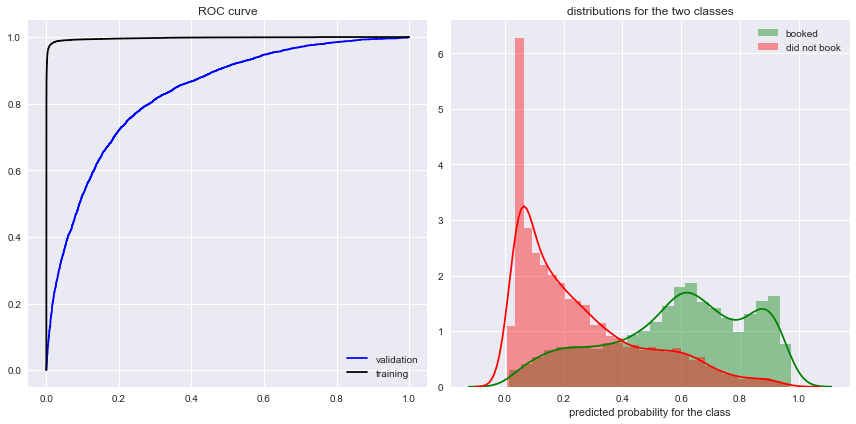

******************************************************************************************
Fold 4 out of 5:
training misclassification (percentage) : 1.66985591155
training log loss : 0.161337703098
training roc auc score : 0.997180113818
validation misclassification (percentage) : 23.1322779013
validation log loss : 0.487743826154
validation roc auc score  : 0.832490165896
oob score: 0.770717825426
------------------------------------------------------------------------------------------


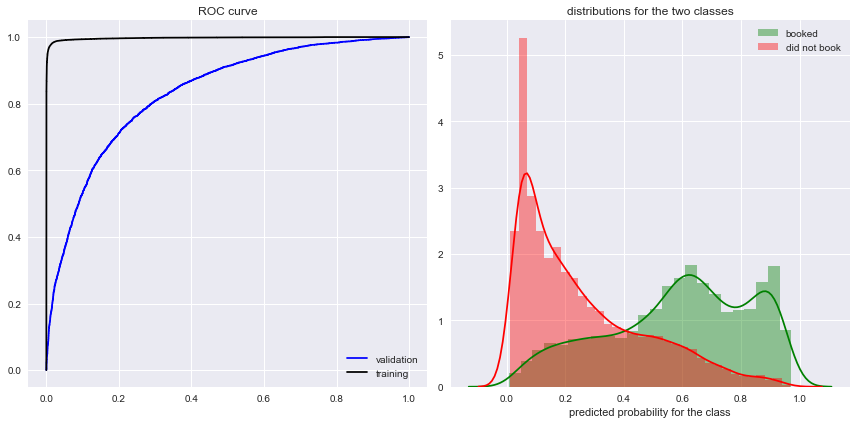

******************************************************************************************
Fold 5 out of 5:
training misclassification (percentage) : 1.62730603166
training log loss : 0.161914164565
training roc auc score : 0.996912961787
validation misclassification (percentage) : 22.4533856722
validation log loss : 0.479981751768
validation roc auc score  : 0.837980109526
oob score: 0.768791704828
------------------------------------------------------------------------------------------


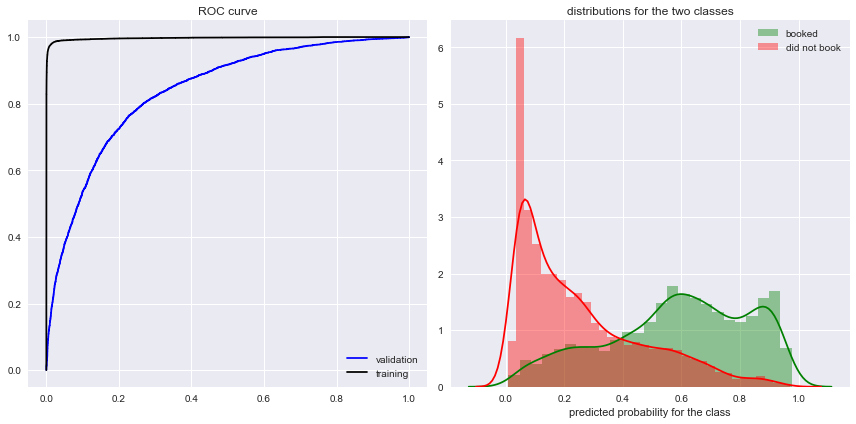

******************************************************************************************


In [18]:
kf = KFold(n_splits=5, shuffle=True)
fold = 0
for train, cv in kf.split(X_users):
    fold = fold + 1
    print 'Fold', fold, 'out of 5:'
    X_train, X_cv = X_users.iloc[train], X_users.iloc[cv]
    y_train, y_cv = y_users.iloc[train], y_users.iloc[cv]
    
#     # this code resample X_train and y_train:
#     samples = np.random.choice(len(X_train), 20000)
#     X_train = X_train.iloc[samples]
#     y_train = y_train.iloc[samples]
    
    # train a random forest 
    clf = RandomForestClassifier(n_estimators=100, oob_score=True, min_impurity_split=0.1)
    #clf = AdaBoostClassifier(n_estimators=500, learning_rate=0.5)
    clf.fit(X_train, y_train)
    
    # check the performance on the training set
    predictions_train = clf.predict(X_train)
    print 'training misclassification (percentage) :', (y_train != predictions_train).sum() * 100. / float(len(y_train))
    prob_train = clf.predict_proba(X_train)
    print 'training log loss :', log_loss(y_train, prob_train)
    print 'training roc auc score :', roc_auc_score(y_train, prob_train[:, 1])
    
    # check the performance on the validation set
    predictions_cv = clf.predict(X_cv)
    print 'validation misclassification (percentage) :', (y_cv != predictions_cv).sum() * 100. / float(len(y_cv))
    prob_cv = clf.predict_proba(X_cv)
    print 'validation log loss :', log_loss(y_cv, prob_cv)
    print 'validation roc auc score  :', roc_auc_score(y_cv, prob_cv[:, 1])
    print 'oob score:', clf.oob_score_
    
    print '-'*90
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    
    # plot the roc curve and probability distributions of the two classes 
    fpr, tpr, thresholds = roc_curve(y_cv, prob_cv[:, 1])
    ax1.plot(fpr, tpr, label='validation', color='blue')
    fpr, tpr, thresholds = roc_curve(y_train, prob_train[:, 1])
    ax1.plot(fpr, tpr, label='training', color='black')
    ax1.legend()
    ax1.set_title('ROC curve')
    
    # plot the probability distribution for the two classes on the validation set
    distr_p1 = pd.Series(prob_cv[:, 1], index=y_cv).loc[1].values
    distr_p0 = pd.Series(prob_cv[:, 1], index=y_cv).loc[0].values
    ax2 = sns.distplot(distr_p1, color='green', label='booked')
    ax2 = sns.distplot(distr_p0, color='red', label='did not book')
    ax2.set_title('distributions for the two classes')
    ax2.set_xlabel('predicted probability for the class')
    ax2.legend()
    fig.tight_layout()
    plt.show()
    print '*'*90

In [19]:
# vary the threshold

for mythreshold in np.linspace(0.45, 0.55, 11):
    print 'threshold:', mythreshold, 'misclassification percentage:', 100. * ((prob_cv[:, 0] > mythreshold) == y_cv).sum()/float(len(y_cv))

threshold: 0.45 misclassification percentage: 23.0356558718
threshold: 0.46 misclassification percentage: 22.8786391887
threshold: 0.47 misclassification percentage: 22.7085377821
threshold: 0.48 misclassification percentage: 22.5842329081
threshold: 0.49 misclassification percentage: 22.5188092902
threshold: 0.5 misclassification percentage: 22.459928034
threshold: 0.51 misclassification percentage: 22.4141315015
threshold: 0.52 misclassification percentage: 22.4991822048
threshold: 0.53 misclassification percentage: 22.5253516519
threshold: 0.54 misclassification percentage: 22.6561988878
threshold: 0.55 misclassification percentage: 22.7412495911


In [20]:
# only keep the features that are important enough and model again

s = pd.Series(clf.feature_importances_).sort_values(ascending=False)

print s[:50].sum(), s[:60].sum(), s[:80].sum()

X_u = X_users[X_users.columns[s.iloc[:80].index]]

0.573733932436 0.626231826358 0.713317065589


Fold 1 out of 5:
training misclassification error (percentage) : 2.19321917472
training log loss : 0.169335777249
training roc auc score : 0.993219610229
validation misclassification error (percentage) : 22.3734135811
validation log loss : 0.482814246887
roc auc score : 0.837346837455
oob score: 0.767168768297
------------------------------


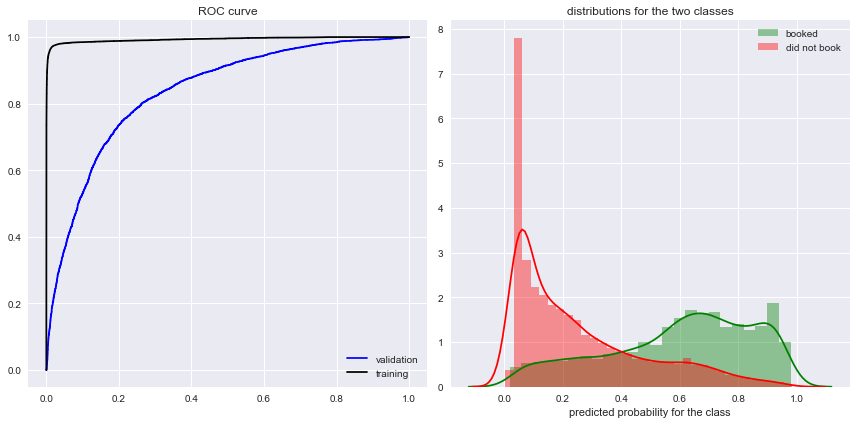

******************************************************************************************
Fold 2 out of 5:
training misclassification error (percentage) : 2.13597631781
training log loss : 0.168351786638
training roc auc score : 0.993832850042
validation misclassification error (percentage) : 23.0079811592
validation log loss : 0.487788271009
roc auc score : 0.831274645318
oob score: 0.768477176455
------------------------------


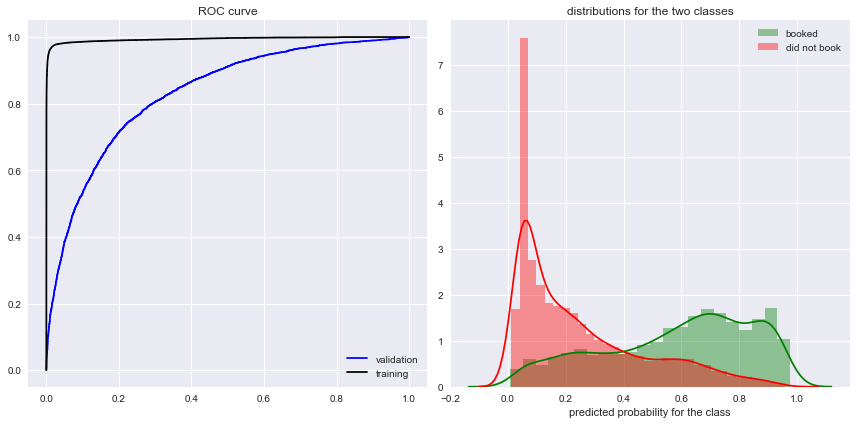

******************************************************************************************
Fold 3 out of 5:
training misclassification error (percentage) : 2.12125672604
training log loss : 0.168120236454
training roc auc score : 0.993898303163
validation misclassification error (percentage) : 22.9752714903
validation log loss : 0.490488315731
roc auc score : 0.830681661881
oob score: 0.768689792781
------------------------------


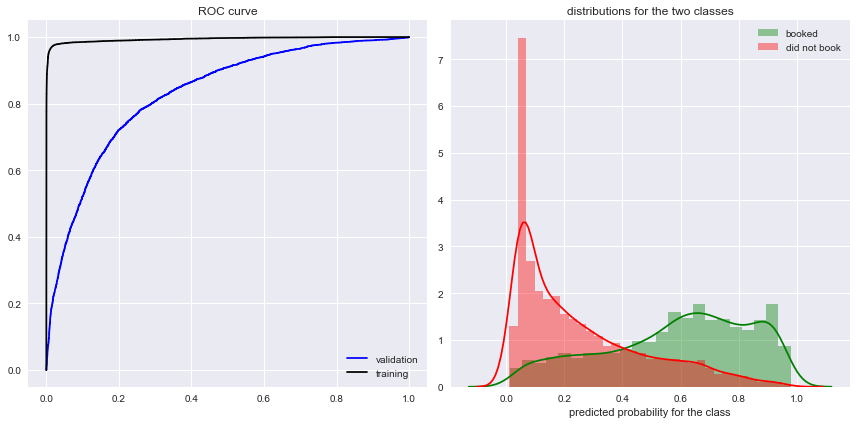

******************************************************************************************
Fold 4 out of 5:
training misclassification error (percentage) : 2.16705101156
training log loss : 0.16906822443
training roc auc score : 0.993489225675
validation misclassification error (percentage) : 22.0790265603
validation log loss : 0.484962939353
roc auc score : 0.835909639744
oob score: 0.767201478501
------------------------------


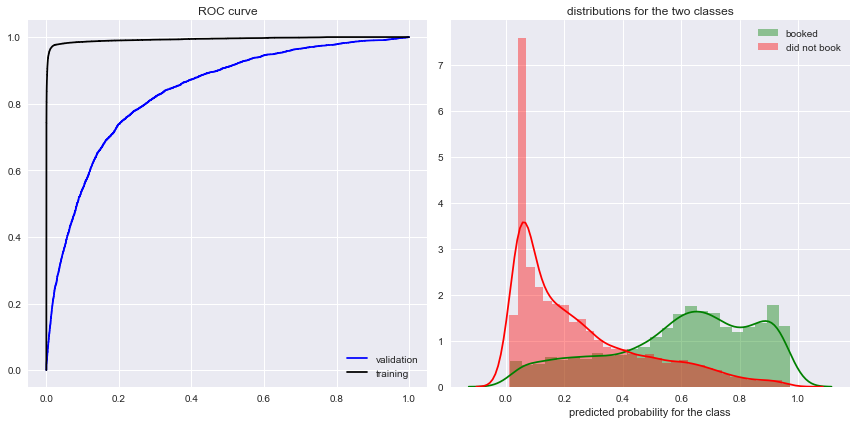

******************************************************************************************
Fold 5 out of 5:
training misclassification error (percentage) : 2.18173492084
training log loss : 0.167343274366
training roc auc score : 0.993966878931
validation misclassification error (percentage) : 23.1207065751
validation log loss : 0.494233152741
roc auc score : 0.82695233443
oob score: 0.770885123643
------------------------------


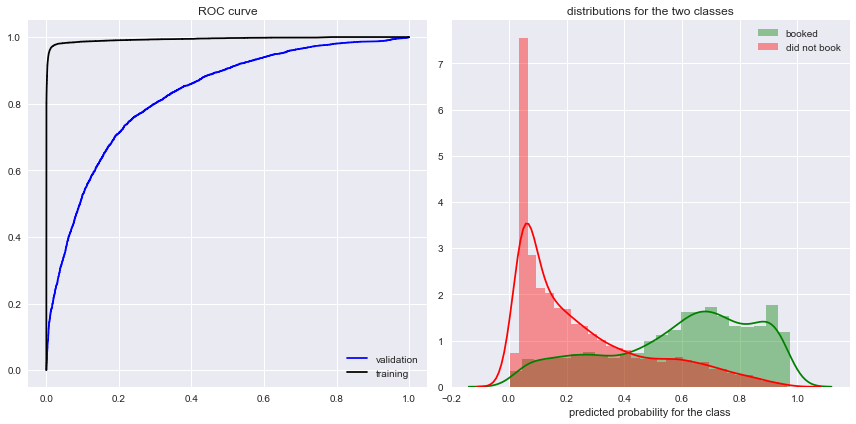

******************************************************************************************


In [21]:
kf = KFold(n_splits=5, shuffle=True)
fold=0
for train, cv in kf.split(X_u):    
    fold = fold + 1
    print 'Fold', fold, 'out of 5:'
    X_train, X_cv = X_u.iloc[train], X_u.iloc[cv]
    y_train, y_cv = y_users.iloc[train], y_users.iloc[cv]
    
    # train a random forest
    newclf = RandomForestClassifier(n_estimators=100, oob_score=True, min_impurity_split=0.1)
    newclf.fit(X_train, y_train)
    
    predictions_train = newclf.predict(X_train)
    print 'training misclassification error (percentage) :', (y_train != predictions_train).sum() * 100. / float(len(y_train))
    prob_train = newclf.predict_proba(X_train)
    print 'training log loss :', log_loss(y_train, prob_train)
    print 'training roc auc score :', roc_auc_score(y_train, prob_train[:, 1])
    
    predictions_cv = newclf.predict(X_cv)
    print 'validation misclassification error (percentage) :', (y_cv != predictions_cv).sum() * 100. / float(len(y_cv))
    prob_cv = newclf.predict_proba(X_cv)
    print 'validation log loss :', log_loss(y_cv, prob_cv)
    print 'roc auc score :', roc_auc_score(y_cv, prob_cv[:, 1])
    print 'oob score:', newclf.oob_score_
    
    print '-'*30
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    
    # plot the roc curve and probability distributions of the two classes 
    fpr, tpr, thresholds = roc_curve(y_cv, prob_cv[:, 1])
    ax1.plot(fpr, tpr, label='validation', color='blue')
    fpr, tpr, thresholds = roc_curve(y_train, prob_train[:, 1])
    ax1.plot(fpr, tpr, label='training', color='black')
    ax1.legend()
    ax1.set_title('ROC curve')
    
    # plot the probability distribution for the two classes on the validation set
    distr_p1 = pd.Series(prob_cv[:, 1], index=y_cv).loc[1].values
    distr_p0 = pd.Series(prob_cv[:, 1], index=y_cv).loc[0].values
    ax2 = sns.distplot(distr_p1, color='green', label='booked')
    ax2 = sns.distplot(distr_p0, color='red', label='did not book')
    ax2.set_title('distributions for the two classes')
    ax2.set_xlabel('predicted probability for the class')
    ax2.legend()
    fig.tight_layout()
    plt.show()
    print '*'*90


In [22]:
# vary the threshold

for mythreshold in np.linspace(0.30, 0.70, 41):
    print 'threshold:', mythreshold, 'misclassification percentage:', 100. * ((prob_cv[:, 0] > mythreshold) == y_cv).sum()/float(len(y_cv))

threshold: 0.3 misclassification percentage: 26.8302257115
threshold: 0.31 misclassification percentage: 26.4376840039
threshold: 0.32 misclassification percentage: 26.1498200851
threshold: 0.33 misclassification percentage: 25.868498528
threshold: 0.34 misclassification percentage: 25.4955839058
threshold: 0.35 misclassification percentage: 25.2338894341
threshold: 0.36 misclassification percentage: 24.8544324501
threshold: 0.37 misclassification percentage: 24.5403990841
threshold: 0.38 misclassification percentage: 24.1805691855
threshold: 0.39 misclassification percentage: 23.9581288845
threshold: 0.4 misclassification percentage: 23.8403663723
threshold: 0.41 misclassification percentage: 23.7487733072
threshold: 0.42 misclassification percentage: 23.5525024534
threshold: 0.43 misclassification percentage: 23.4936211973
threshold: 0.44 misclassification percentage: 23.3824010468
threshold: 0.45 misclassification percentage: 23.375858685
threshold: 0.46 misclassification percentage

# Ignore what follows

In [23]:
stop_here = 

SyntaxError: invalid syntax (<ipython-input-23-ce4420942638>, line 1)

In [ ]:
featurelist = X_u.columns
for i,x in enumerate(featurelist):
    for y in featurelist[i:]:
        X_u.loc[:, x + '*' + y] = X_u.loc[:, x] * X_u.loc[:, y]
print 'Yay! added more features!'

In [ ]:
fpr, tpr, thresholds = roc_curve(y_cv, prob_cv[:, 1])
fig, ax = plt.subplots()
#plt.plot(thresholds, fpr, color='blue')
#plt.plot(thresholds, tpr, color='green')
plt.plot(fpr, tpr)

In [ ]:
X_u.columns

In [ ]:
sessions.groupby(['user_id', 'action']).size().unstack()

In [ ]:
view = sessions.groupby(['user_id', 'action_type']).size().unstack().view
train_users['view'] = train_users.join(view).view.fillna(0)

In [ ]:
# add booking_request data

booking_request = sessions.groupby(['user_id', 'action_type']).size().unstack().booking_request
train_users['booking_request'] = train_users.join(booking_request).booking_request.fillna(0)

In [ ]:
# add the clicks data

click_series = sessions.groupby(['user_id', 'action_type']).size().unstack().click.sort_index()
train_users['click'] = train_users.join(click_series).click.fillna(0)

In [ ]:
train_users.set_index('id').loc[np.setdiff1d(train_users.id.unique(), sessions.user_id.unique())].groupby(['country_destination', 'year']).size().unstack()[2014].sum()

In [ ]:
# all the users in the sessions table are from 2014

train_users.set_index('id').loc[np.intersect1d(train_users.id.unique(), sessions.user_id.unique())].groupby(['year']).size()

In [ ]:
len(booked_ya), len(booked_na)

In [ ]:
len(np.intersect1d(ids.unique(), sessions.user_id.unique()))

In [ ]:
len(booked_ya), len(booked_na)

In [ ]:
train_users.isnull().sum().sort_values()

In [ ]:
ids = train_users.index

numeric = pd.DataFrame(pd.Series(data=0, index = ids))

# add features coming from the sessions table 

for y in ['action', 'action_type', 'action_detail']:
    df = sessions.groupby(['user_id', y]).size().unstack()

    for x in df.columns:
        s = df[x]
        numeric[y + '_' + x] = numeric.join(s)[x].fillna(0)

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(numeric)
numeric = pca.transform(numeric)

len(pca.explained_variance_ratio_[pca.explained_variance_ratio_ > 0.001])

numeric = pd.DataFrame(numeric[:,:22], index=ids)

In [ ]:
train_users = train_users.join(numeric)

In [ ]:
s = sessions.groupby(['user_id', 'action_type']).size().unstack().booking_response.fillna(0)

In [ ]:
s.head(20)

In [ ]:
y_users.loc[s.sort_index().index].head(20)

In [ ]:
s[:150].sum()